In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import json
import os
co_path ='E:\dataset'
os.chdir(co_path)
os.listdir(co_path)

['ocs_result', 'winemag-data-130k-v2.csv', 'winemag-data_first150k.csv']

In [2]:
class Apriori(object): #Apriori algorithm
    def __init__(self, min_support = 0.1, min_confidence = 0.5):
        self.min_support = min_support
        self.min_confidence = min_confidence

    def get_frequent_items(self, dataset):
        # 构建可能的单元素候选项集合
        C1 = []
        for data in dataset:
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        C1 = [frozenset(item) for item in C1]
        
        dataset = [set(data) for data in dataset]
    
        L1, support_data = self._filter(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self._gen(L[k-2], k)
            Lk, support_k = self._filter(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data
    
    def _filter(self, dataset, Ck):
        # 判断数据集D中Ck元素的出现频率
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤掉低于最小支持度的项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def _gen(self, Lk, k):
        #合并的同时处理重复
        return_list = []
        len_Lk = len(Lk)
        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时，将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def get_rules(self, L, support_data):
        # 使用分级法生成关联规则
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self._generate_rules(freq_set, H1, support_data, big_rules_list)
                else:
                    self._eval(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def _generate_rules(self, freq_set, H, support_data, big_rules_list):
        # 递归生成规则
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self._gen(H, m+1)
            Hmp1 = self._eval(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self._generate_rules(freq_set, Hmp1, support_data, big_rules_list)

    def _eval(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            jaccard = sup / (support_data[freq_set - conseq] + support_data[conseq] - sup)
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift,jaccard))
                prunedH.append(conseq)
        return prunedH
    

In [3]:
min_support = 0.1
min_confidence = 0.5
head_n = 50000
apriori = Apriori(min_support=min_support,min_confidence=min_confidence)

# 读取数据至数据字典
data = pd.read_csv("winemag-data_first150k.csv", encoding="utf-8")
attributes=["country", "description", "designation", "points", "price", "province", "region_1", "region_2", "winery"]
data_ = data[attributes]
data_all = data_.dropna(how='any')
rows = None
rows = data_all.head(head_n).values.tolist()
dataset = []
for data_line in rows:
    data_set = []
    for i, value in enumerate(data_line):
        if not value:
            data_set.append((attributes[i], 'NA'))
        else:
            data_set.append((attributes[i], value))
    dataset.append(data_set)

print("start")
# 获取频繁项集
freq_set, sup_rata = apriori.get_frequent_items(dataset)
sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
# 获取关联规则
strong_rules_list = apriori.get_rules(freq_set, sup_rata)
strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)
print("end")

# 分别存储频繁项集和关联规则
freq_set_file = open("./ocs_result/fterms.json", 'w')
for (key, value) in sup_rata_out:
    result_dict = {'set': None, 'sup': None}
    set_result = list(key)
    sup_result = value
    if sup_result < min_support:
        continue
    result_dict['set'] = set_result
    result_dict['sup'] = sup_result
    json_str = json.dumps(result_dict, ensure_ascii=False)
    freq_set_file.write(json_str + '\n')
freq_set_file.close()
rules_file = open("./ocs_result/rules.json", 'w')
for result in strong_rules_list:
    result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
    X_set, Y_set, sup, conf, lift, jaccard = result
    result_dict['X_set'] = list(X_set)
    result_dict['Y_set'] = list(Y_set)
    result_dict['sup'] = sup
    result_dict['conf'] = conf
    result_dict['lift'] = lift
    result_dict['jaccard'] = jaccard
    json_str = json.dumps(result_dict, ensure_ascii=False)
    rules_file.write(json_str + '\n')
rules_file.close()
print("save done")


start
end
save done


In [4]:
with open("./ocs_result/fterms.json") as f1:
    freq = [json.loads(each) for each in f1.readlines()]
    freq_sup = [each["sup"] for each in freq]
    print("freq:")
    print(freq)

freq:
[{'set': [['country', 'US']], 'sup': 1.0}, {'set': [['province', 'California']], 'sup': 0.7277337478657526}, {'set': [['province', 'California'], ['country', 'US']], 'sup': 0.7277337478657526}, {'set': [['region_2', 'Central Coast']], 'sup': 0.2331744858693713}, {'set': [['province', 'California'], ['region_2', 'Central Coast']], 'sup': 0.2331744858693713}, {'set': [['country', 'US'], ['region_2', 'Central Coast']], 'sup': 0.2331744858693713}, {'set': [['province', 'California'], ['country', 'US'], ['region_2', 'Central Coast']], 'sup': 0.2331744858693713}, {'set': [['region_2', 'Sonoma']], 'sup': 0.19841492316709564}, {'set': [['province', 'California'], ['region_2', 'Sonoma']], 'sup': 0.19841492316709564}, {'set': [['country', 'US'], ['region_2', 'Sonoma']], 'sup': 0.19841492316709564}, {'set': [['province', 'California'], ['country', 'US'], ['region_2', 'Sonoma']], 'sup': 0.19841492316709564}, {'set': [['province', 'Washington']], 'sup': 0.15601029535434877}, {'set': [['countr

In [5]:
with open("./ocs_result/rules.json") as f2:
    rules = [json.loads(each) for each in f2.readlines()]
    rules_sup = [each["sup"] for each in rules]
    rules_conf = [each["conf"] for each in rules]
    print("rules:")
    print(rules)

rules:
[{'X_set': [['points', 87]], 'Y_set': [['country', 'US']], 'sup': 0.12530261716062283, 'conf': 1.0, 'lift': 7.980679275981289, 'jaccard': 0.12530261716062283}, {'X_set': [['points', 88]], 'Y_set': [['country', 'US']], 'sup': 0.10552738207487067, 'conf': 1.0, 'lift': 9.476213475006038, 'jaccard': 0.10552738207487067}, {'X_set': [['points', 90]], 'Y_set': [['country', 'US']], 'sup': 0.11115924670625112, 'conf': 1.0, 'lift': 8.996102705181109, 'jaccard': 0.11115924670625112}, {'X_set': [['province', 'Washington']], 'Y_set': [['country', 'US']], 'sup': 0.15601029535434877, 'conf': 1.0, 'lift': 6.409833387781771, 'jaccard': 0.15601029535434877}, {'X_set': [['region_2', 'Columbia Valley']], 'Y_set': [['country', 'US']], 'sup': 0.1474223388802528, 'conf': 1.0, 'lift': 6.783232497839239, 'jaccard': 0.1474223388802528}, {'X_set': [['region_2', 'Columbia Valley']], 'Y_set': [['province', 'Washington']], 'sup': 0.1474223388802528, 'conf': 1.0, 'lift': 6.783232497839239, 'jaccard': 0.944952

In [ ]:
可以看出，在没有输入各个属性之间关系的情况下，学习到了country和province的关系（例California的一定是America的），说明这种方法能正确的学到频繁模式与强关联规则

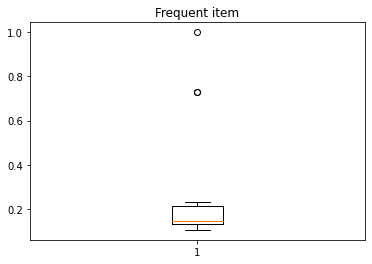

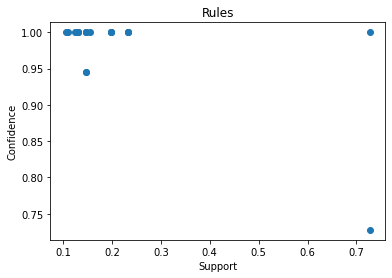

In [6]:
plt.figure(1)
plt.boxplot(freq_sup)
plt.title("Frequent item")
plt.show()

plt.figure(2)
plt.scatter(rules_sup, rules_conf)
plt.title("Rules")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()
